In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


In [3]:
df = pd.read_csv("dataset.csv", encoding='utf-8')
df['text'] = df['subject'].fillna('') + " " + df['body'].fillna('')

print("5 dòng đầu của dataset:")
print(df[['id', 'subject', 'body', 'label']].head())


5 dòng đầu của dataset:
   id                                      subject  \
0   1      Thông báo vi phạm và yêu cầu thanh toán   
1   2                       Thông báo trúng thưởng   
2   3                       Đơn của bạn bị từ chối   
3   4  Đảm bảo giảm 10–12 cân trong 30 ngày 10.162   
4   5                        Cơ hội việc làm ở nhà   

                                                body label  
0  Xin chào, Bạn đang vi phạm Khoản 1 Điều 466 Bộ...  spam  
1  Xin chúc mừng bạn dxdiag@gmail.com đã trúng th...  spam  
2  Bạn đang ngập trong nợ nần?\nĐây là những gì c...  spam  
3  Đánh bại nguy cơ ung thư!\nhttp://www.adclick....  spam  
4  Một cơ hội kinh doanh tại nhà đang gõ cửa nhà ...  spam  


In [4]:
def preprocess(text):
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]
    return ". ".join(lines) + "." if lines else ""


import string

def viet_tokenize(text):
    tokens = word_tokenize(text, format='text').split()
    # loại bỏ token chỉ toàn dấu câu
    tokens = [t for t in tokens if any(c.isalnum() for c in t)]
    return tokens


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)


In [6]:
with open("vietnamese-stopwords-dash.txt", "r", encoding="utf-8") as f:
    viet_stopwords = [line.strip() for line in f if line.strip()]

vectorizer = TfidfVectorizer(tokenizer=viet_tokenize, stop_words=viet_stopwords)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


C:\Users\phama\PycharmProjects\PythonProject\.venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\phama\PycharmProjects\PythonProject\.venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tòa'] not in stop_words.
  warnings.warn(


In [7]:
model = MultinomialNB(alpha=0.5)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         ham       0.94      0.85      0.89        20
        spam       0.91      0.97      0.94        30

    accuracy                           0.92        50
   macro avg       0.93      0.91      0.92        50
weighted avg       0.92      0.92      0.92        50



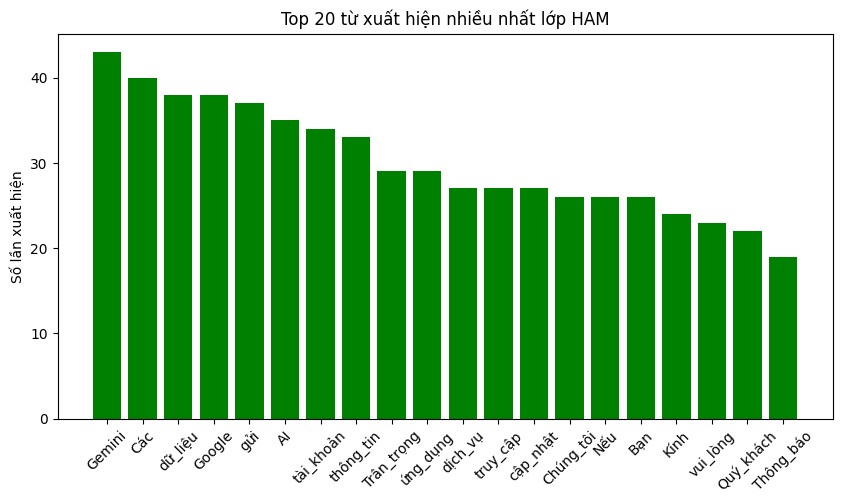

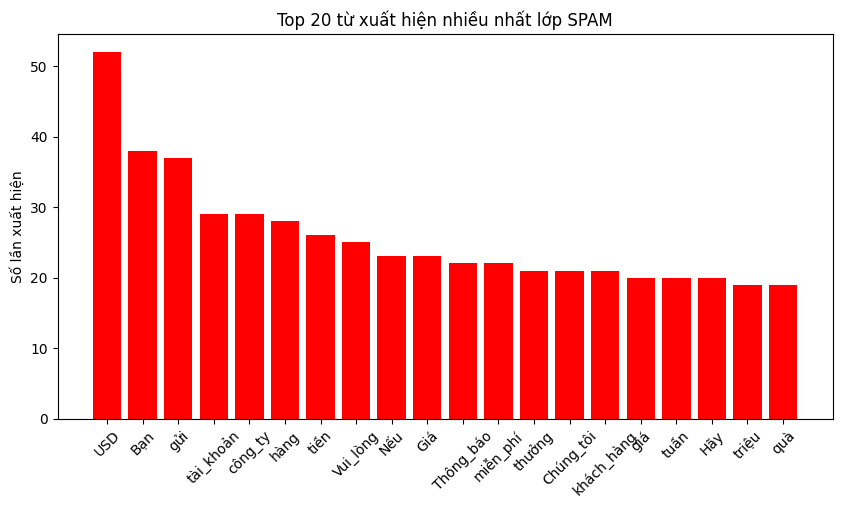

In [10]:
from collections import defaultdict


# Hàm đếm số lần xuất hiện
def count_words(texts, labels, target_label):
    counter = defaultdict(int)
    for text, label in zip(texts, labels):
        if label == target_label:
            for w in viet_tokenize(text):
                if w not in viet_stopwords:
                    counter[w] += 1
    return counter


ham_words = count_words(X_train, y_train, 'ham')
spam_words = count_words(X_train, y_train, 'spam')

# Top 10 từ
top_k = 20
ham_top = sorted(ham_words.items(), key=lambda x: x[1], reverse=True)[:top_k]
spam_top = sorted(spam_words.items(), key=lambda x: x[1], reverse=True)[:top_k]

# Vẽ bar chart HAM
plt.figure(figsize=(10, 5))
plt.bar([w for w, _ in ham_top], [c for _, c in ham_top], color='green')
plt.xticks(rotation=45)
plt.title("Top 20 từ xuất hiện nhiều nhất lớp HAM")
plt.ylabel("Số lần xuất hiện")
plt.show()

# Vẽ bar chart SPAM
plt.figure(figsize=(10, 5))
plt.bar([w for w, _ in spam_top], [c for _, c in spam_top], color='red')
plt.xticks(rotation=45)
plt.title("Top 20 từ xuất hiện nhiều nhất lớp SPAM")
plt.ylabel("Số lần xuất hiện")
plt.show()


In [17]:
subj_input = input("\nNhập Subject (tiêu đề): ")
body_input = input("Nhập Body (nội dung): ")
email_text = subj_input + " " + body_input

X_new = vectorizer.transform([email_text])
pred_label = model.predict(X_new)[0]
pred_prob = np.max(model.predict_proba(X_new))

print("\n--- KẾT QUẢ DỰ ĐOÁN ---")
print(f"Subject:\n{subj_input}")
print(f"Body:\n{body_input}\n")
print(f"Dự đoán: {pred_label}")
print(f"Tỉ lệ (%): {pred_prob * 100:.2f}%")

time_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
new_row = pd.DataFrame([{
    "subject": subj_input,
    "body": body_input,
    "pred": pred_label,
    "probability (%)": pred_prob * 100,
    "time": time_now
}])

csv_file = "filter_history.csv"
if os.path.exists(csv_file):
    new_row.to_csv(csv_file, mode='a', index=False, header=False, encoding='utf-8')
else:
    new_row.to_csv(csv_file, index=False, encoding='utf-8')

print(f"\nĐã lưu dự đoán vào {csv_file}")
print("----------")
print("Lưu ý: Kết quả chỉ mang tính tham khảo. Vui lòng không nhập thông tin nhạy cảm, đường link, hay điền vào form trong email.")




--- KẾT QUẢ DỰ ĐOÁN ---
Subject:
[Bitmart] 🔥 DÀNH RIÊNG CHO【VIỆT NAM】 - Hơn 90% đồng bào đang sôi nổi tham gia!
Body:
Kính gửi Người dùng BitMart,
 
Sự kiện ưu đãi siêu hấp dẫn sắp kết thúc! Đừng bỏ lỡ cơ hội cuối cùng!
Thời gian kết thúc: 04:59:59 UTC ngày 11/09/2025
【NHẬN THƯỞNG NGAY】
✅ 【Lợi nhuận an toàn】Gửi tiền nhận ngay 10% hoàn trả - Rủi ro 0%
✅ 【Ưu đãi cho người mới】Giao dịch đầu tiên nhận ngay 200 USDT
✅ 【Cộng đồng sôi động】Người dùng mới và cũ cùng nhau chia sẻ giải thưởng 20.000 USDT
 
Đừng bỏ lỡ bữa tiệc ưu đãi siêu hấp dẫn này, được thiết kế đặc biệt dành riêng cho người dùng Việt Nam!
Cảnh báo rủi ro: Giao dịch tiền mã hóa chịu nhiều rủi ro từ thị trường. BitMart sẽ luôn cố gắng chọn các coin chất lượng, nhưng không chịu trách nhiệm về các tổn thất của bạn khi giao dịch. Vui lòng giao dịch một cách thận trọng.
Copyright 2017-2025 © bitmart.com.

Dự đoán: spam
Tỉ lệ (%): 88.39%

Đã lưu dự đoán vào filter_history.csv
----------
Lưu ý: Kết quả chỉ mang tính tham khảo. Vui l